# Bonus Tutorial: Autoencoder and Embeddings

<p>
Bern Winter School on Machine Learning, 2023<br>
Prepared by Mykhailo Vladymyrov and Matthew Vowels.
</p>

This work is licensed under a <a href="http://creativecommons.org/licenses/by-nc-sa/4.0/">Creative Commons Attribution-NonCommercial-ShareAlike 4.0 International License</a>.

In this session we will create a fully-connected autoencoder

## 1. Load necessary libraries



In [2]:
import os
import sys
import tarfile
import requests

import random
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import torch.utils.data
from torch.utils.data import TensorDataset, DataLoader



# URL of the file to download
url = 'https://github.com/neworldemancer/BMLWS/raw/main/tut_files/tpub0320.tgz'

# Path where the file will be saved
path = os.path.abspath('.') + '/material.tgz'

# Download the file
response = requests.get(url)
assert response.status_code == 200, "Download failed"
with open(path, 'wb') as file:
    file.write(response.content)

# Check if the path is correct
assert os.path.exists(path), "File not found"

# Extract the tar file
tar = tarfile.open(path, "r:gz")
tar.extractall()
tar.close()

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 9.91M/9.91M [00:00<00:00, 10.6MB/s]


Extracting /root/.pytorch/MNIST_data/MNIST/raw/train-images-idx3-ubyte.gz to /root/.pytorch/MNIST_data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 28.9k/28.9k [00:00<00:00, 341kB/s]


Extracting /root/.pytorch/MNIST_data/MNIST/raw/train-labels-idx1-ubyte.gz to /root/.pytorch/MNIST_data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 1.65M/1.65M [00:00<00:00, 3.20MB/s]


Extracting /root/.pytorch/MNIST_data/MNIST/raw/t10k-images-idx3-ubyte.gz to /root/.pytorch/MNIST_data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 4.54k/4.54k [00:00<00:00, 7.28MB/s]


Extracting /root/.pytorch/MNIST_data/MNIST/raw/t10k-labels-idx1-ubyte.gz to /root/.pytorch/MNIST_data/MNIST/raw

Train dataset shape: 60000 total images and labels
Test dataset shape: 10000 total images and labels


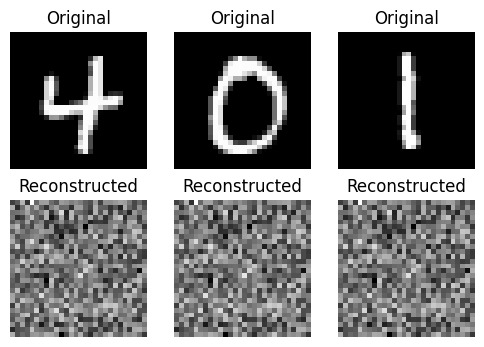

Epoch 1/5, Train Loss: 0.2684


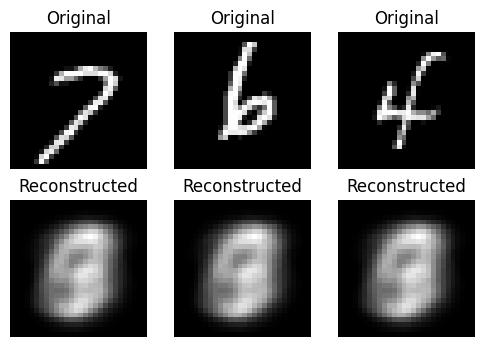

KeyboardInterrupt: 

In [2]:
transform = transforms.Compose([transforms.ToTensor(),  # Scales the pixel values to the range [0, 1]
    transforms.Lambda(lambda x: torch.flatten(x))])

# Download and load the training data
trainset = datasets.MNIST('~/.pytorch/MNIST_data/', download=True, train=True, transform=transform)
trainloader = DataLoader(trainset, batch_size=64, shuffle=True)

# Download and load the test data
testset = datasets.MNIST('~/.pytorch/MNIST_data/', download=True, train=False, transform=transform)
testloader = DataLoader(testset, batch_size=64, shuffle=True)

# Print shapes of the datasets
print('Train dataset shape:', len(trainset), 'total images and labels')
print('Test dataset shape:', len(testset), 'total images and labels')


class AutoEncoder(nn.Module):
    def __init__(self, n_input, n_hidden, latent_dim):
        super(AutoEncoder, self).__init__()
        self.encl1 = nn.Linear(n_input, n_hidden)
        self.encl2 = nn.Linear(n_hidden, n_hidden)
        self.encl4 = nn.Linear(n_hidden, latent_dim)

        self.decl1 = nn.Linear(latent_dim, n_hidden)
        self.decl2 = nn.Linear(n_hidden, n_hidden)
        self.decl4 = nn.Linear(n_hidden, n_input)

    def forward(self, x):
        enc = F.tanh(self.encl4(
                F.relu(self.encl2(
                    F.relu(self.encl1(x))))))

        dec = torch.sigmoid(self.decl4(
                F.relu(self.decl2(
                    F.relu(self.decl1(enc))))))

        return enc, dec


def train(model, trainloader, criterion, optimizer):
    model.train()
    running_loss = 0.0
    for i, (images, _) in enumerate(trainloader):
        optimizer.zero_grad()  # reset gradients
        encodings, decodings = model(images)
        loss = criterion(decodings, images)
        loss.backward()    # compute gradients
        optimizer.step()   # update parameters with gradients
        running_loss += loss.item()

        if i == 0:  # Visualize for the first batch of each epoch
            model.eval()
            with torch.no_grad():
              _, sample_decodings = model(images[:num_viz_images])
            visualize_reconstruction(images[:num_viz_images], sample_decodings)
            model.train()

    return running_loss / len(trainloader)


def visualize_reconstruction(original, reconstructed, num_images=5):
    # Check if there are enough images
    num_available = min(original.size(0), reconstructed.size(0), num_images)

    original = original.view(original.size(0), 28, 28)  # Reshape to 28x28 if needed
    reconstructed = reconstructed.view(reconstructed.size(0), 28, 28)

    fig, axes = plt.subplots(nrows=2, ncols=num_available, figsize=(2 * num_available, 4))
    for i in range(num_available):
        # Display original
        axes[0, i].imshow(original[i].cpu().numpy(), cmap='gray')
        axes[0, i].set_title("Original")
        axes[0, i].axis('off')

        # Display reconstruction
        axes[1, i].imshow(reconstructed[i].cpu().numpy(), cmap='gray')
        axes[1, i].set_title("Reconstructed")
        axes[1, i].axis('off')

    plt.show()



criterion = nn.BCELoss()

ae = AutoEncoder(n_input=784, n_hidden=256, latent_dim=64)

optimizer = optim.Adam(ae.parameters(), lr=1e-3)
num_viz_images = 3

num_epochs = 5
train_losses = []

for epoch in range(num_epochs):
    train_loss = train(model=ae, trainloader=trainloader, criterion=criterion, optimizer=optimizer)

    train_losses.append(train_loss)

    print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}')


## 5. Load the data

First we will load the data: 60000 training images and 10000 images for validation with some included data transformations.

Each image is a 28x28 pixels. For this model we will interpret it as a 1D array of 784 elements.

100%|██████████| 9912422/9912422 [00:00<00:00, 112254835.70it/s]


Extracting /root/.pytorch/MNIST_data/MNIST/raw/train-images-idx3-ubyte.gz to /root/.pytorch/MNIST_data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 71298230.62it/s]


Extracting /root/.pytorch/MNIST_data/MNIST/raw/train-labels-idx1-ubyte.gz to /root/.pytorch/MNIST_data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 32213383.93it/s]


Extracting /root/.pytorch/MNIST_data/MNIST/raw/t10k-images-idx3-ubyte.gz to /root/.pytorch/MNIST_data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 4844997.14it/s]


Extracting /root/.pytorch/MNIST_data/MNIST/raw/t10k-labels-idx1-ubyte.gz to /root/.pytorch/MNIST_data/MNIST/raw

Train dataset shape: 60000 total images and labels
Test dataset shape: 10000 total images and labels


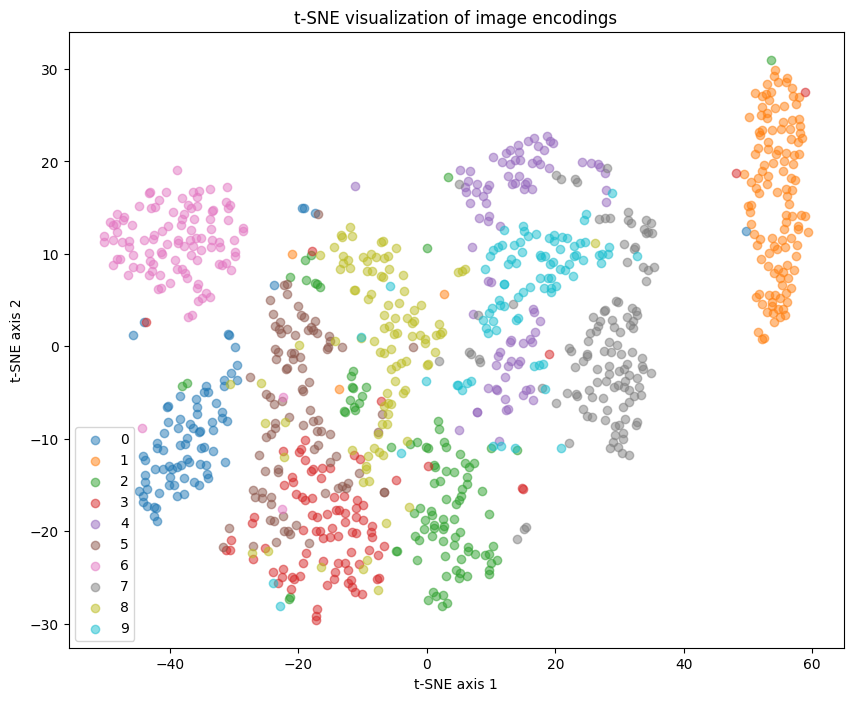

In [ ]:
from sklearn.manifold import TSNE  # UMAP

def visualize_encodings(model, dataloader, num_samples=1000):
    model.eval()
    embeddings = []
    labels = []

    # Collect encodings and labels
    with torch.no_grad():
        for i, (images, label) in enumerate(trainloader):
            if len(embeddings) >= num_samples:
                break
            enc, _ = model(images)
            embeddings.append(enc)
            labels.append(label)

    # Convert lists to tensors
    embeddings = torch.cat(embeddings)[:num_samples]
    labels = torch.cat(labels)[:num_samples]

    # Run t-SNE
    tsne = TSNE(n_components=2, random_state=1)
    embeddings_2d = tsne.fit_transform(embeddings.cpu().numpy())

    # Plot
    plt.figure(figsize=(10, 8))
    for i in range(10):  # Assuming 10 classes (0-9) for MNIST
        indices = labels == i
        plt.scatter(embeddings_2d[indices, 0], embeddings_2d[indices, 1], label=str(i), alpha=0.5)
    plt.legend()
    plt.title("t-SNE visualization of image encodings")
    plt.xlabel("t-SNE axis 1")
    plt.ylabel("t-SNE axis 2")
    plt.show()

# Example usage
visualize_encodings(ae, trainloader)

Train dataset size: 60000
Test dataset size : 10000


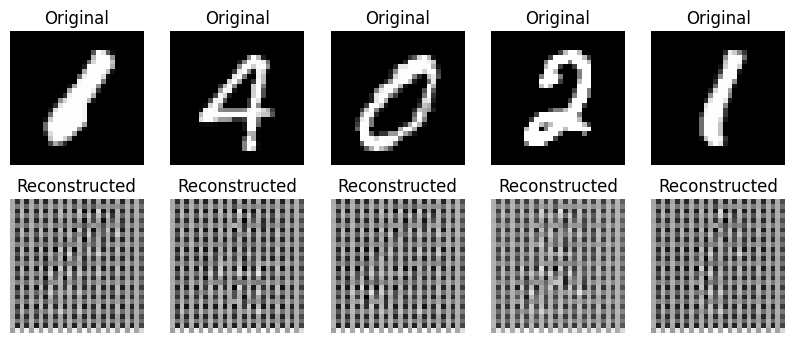

Epoch 1/5, Train Loss: 0.1581


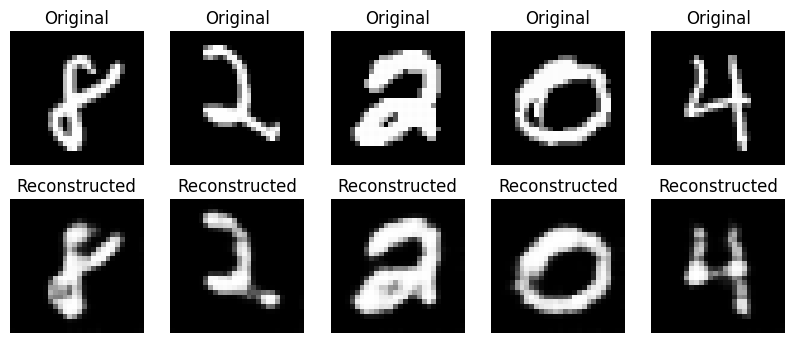

Epoch 2/5, Train Loss: 0.0898


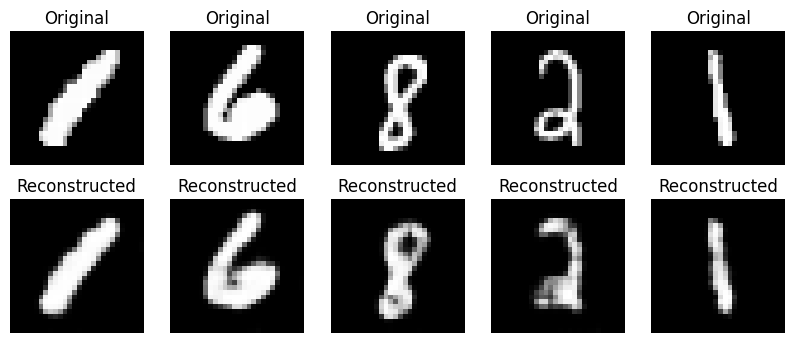

Epoch 3/5, Train Loss: 0.0862


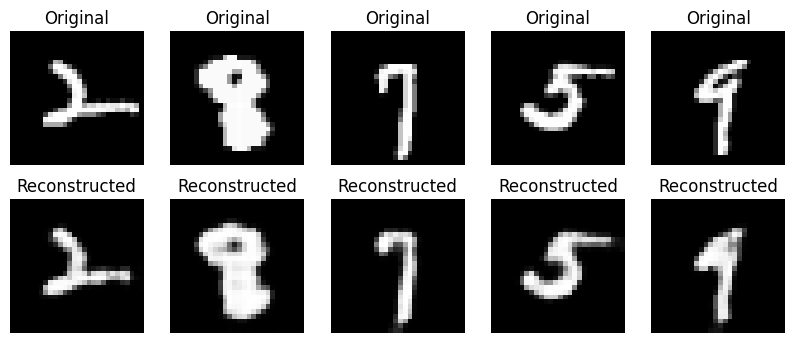

Epoch 4/5, Train Loss: 0.0789


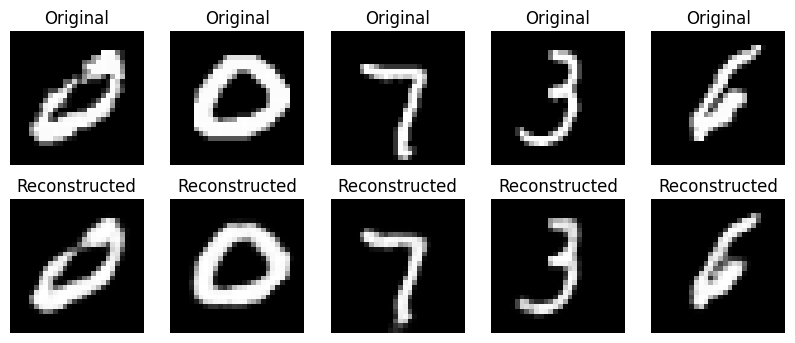

Epoch 5/5, Train Loss: 0.0749
AE Embeddings - Train shape: (60000, 196)
AE Embeddings - Test  shape: (10000, 196)
Random Forest (on AE embeddings) Accuracy: 0.9615
Raw Images - Train shape: (60000, 784)
Raw Images - Test  shape: (10000, 784)
Random Forest (on raw images) Accuracy: 0.9697

--- Comparison of Random Forest Results ---
  * On AE embeddings : 0.9615
  * On raw images    : 0.9697


In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score


transform = transforms.Compose([
    transforms.ToTensor(),  # Keep images in [0,1] range, shape: (1, 28, 28)
])

trainset = datasets.MNIST(root='~/.pytorch/MNIST_data/', download=True, train=True, transform=transform)
trainloader = DataLoader(trainset, batch_size=64, shuffle=True)

testset = datasets.MNIST(root='~/.pytorch/MNIST_data/', download=True, train=False, transform=transform)
testloader = DataLoader(testset, batch_size=64, shuffle=False)

print('Train dataset size:', len(trainset))
print('Test dataset size :', len(testset))

class ConvAutoEncoder(nn.Module):
    def __init__(self):
        """
        A simple convolutional autoencoder:

        Encoder:
          1) Conv2d(1 -> 16)
          2) Conv2d(16 -> 4)

        Decoder (mirroring the encoder):
          1) ConvTranspose2d(4 -> 16)
          2) ConvTranspose2d(16 -> 1)
        """
        super(ConvAutoEncoder, self).__init__()

        # Encoder: [B, 1, 28, 28] -> [B, 4, 7, 7]
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, stride=2, padding=1),  # -> [B, 16, 14, 14]
            nn.ReLU(True),
            nn.Conv2d(16, 4, kernel_size=3, stride=2, padding=1),   # -> [B, 4, 7, 7]
            nn.ReLU(True)
        )

        # Decoder: [B, 4, 7, 7] -> [B, 1, 28, 28]
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(4, 16, kernel_size=3, stride=2,
                               padding=1, output_padding=1),         # -> [B, 16, 14, 14]
            nn.ReLU(True),
            nn.ConvTranspose2d(16, 1, kernel_size=3, stride=2,
                               padding=1, output_padding=1),          # -> [B, 1, 28, 28]
            nn.Sigmoid()  # Output in [0,1]
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x



def visualize_reconstruction(original, reconstructed, num_images=5):
    # `original` and `reconstructed` should be shapes [B, 1, 28, 28]
    num_available = min(original.size(0), reconstructed.size(0), num_images)

    fig, axes = plt.subplots(nrows=2, ncols=num_available, figsize=(2 * num_available, 4))
    for i in range(num_available):
        # Original image
        axes[0, i].imshow(original[i, 0].cpu().numpy(), cmap='gray')
        axes[0, i].set_title("Original")
        axes[0, i].axis('off')

        # Reconstructed image
        axes[1, i].imshow(reconstructed[i, 0].cpu().numpy(), cmap='gray')
        axes[1, i].set_title("Reconstructed")
        axes[1, i].axis('off')

    plt.show()


def train(model, dataloader, criterion, optimizer, num_viz_images=5):
    model.train()
    running_loss = 0.0

    for batch_idx, (images, _) in enumerate(dataloader):
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, images)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

        # Visualize reconstruction (only on the first batch per epoch)
        if batch_idx == 0:
            model.eval()
            with torch.no_grad():
                sample_outputs = model(images[:num_viz_images])
            visualize_reconstruction(images[:num_viz_images], sample_outputs)
            model.train()

    return running_loss / len(dataloader)

model = ConvAutoEncoder()
criterion = nn.BCELoss()  # Could also use MSELoss, etc.
optimizer = optim.Adam(model.parameters(), lr=1e-3)

num_epochs = 5
train_losses = []
for epoch in range(num_epochs):
    train_loss = train(model, trainloader, criterion, optimizer)
    train_losses.append(train_loss)
    print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}')


def get_embeddings(model, dataloader):
    """
    Passes all data in dataloader through the model.encoder,
    flattens the output, and returns embeddings (X) and labels (y).
    """
    model.eval()  # Important: disable dropout, etc.
    all_embeddings = []
    all_labels = []

    with torch.no_grad():
        for images, labels in dataloader:
            # Get the latent embeddings from the encoder
            latent = model.encoder(images)             # shape: [B, 4, 7, 7]
            latent = latent.view(latent.size(0), -1)   # flatten to [B, 4*7*7=196]

            all_embeddings.append(latent.cpu().numpy())
            all_labels.append(labels.numpy())

    # Concatenate all batches
    X = np.concatenate(all_embeddings, axis=0)
    y = np.concatenate(all_labels, axis=0)

    return X, y

X_train, y_train = get_embeddings(model, trainloader)
X_test,  y_test  = get_embeddings(model, testloader)

print("AE Embeddings - Train shape:", X_train.shape)
print("AE Embeddings - Test  shape:", X_test.shape)


rf_embeddings = RandomForestClassifier(n_estimators=100, random_state=42)
rf_embeddings.fit(X_train, y_train)

# Evaluate on test
y_pred_ae = rf_embeddings.predict(X_test)
acc_ae = accuracy_score(y_test, y_pred_ae)
print(f"Random Forest (on AE embeddings) Accuracy: {acc_ae:.4f}")


def get_raw_images(dataloader):
    """
    Flattens the original MNIST images (28x28=784) into 1D vectors
    and returns them along with their labels.
    """
    all_raw = []
    all_labels = []
    for images, labels in dataloader:
        # images.shape = [B, 1, 28, 28] -> flatten to [B, 28*28]
        raw = images.view(images.size(0), -1)
        all_raw.append(raw.cpu().numpy())
        all_labels.append(labels.numpy())

    X = np.concatenate(all_raw, axis=0)
    y = np.concatenate(all_labels, axis=0)
    return X, y

X_train_raw, y_train_raw = get_raw_images(trainloader)
X_test_raw,  y_test_raw = get_raw_images(testloader)

print("Raw Images - Train shape:", X_train_raw.shape)
print("Raw Images - Test  shape:", X_test_raw.shape)

rf_raw = RandomForestClassifier(n_estimators=100, random_state=42)
rf_raw.fit(X_train_raw, y_train_raw)

y_pred_raw = rf_raw.predict(X_test_raw)
acc_raw = accuracy_score(y_test_raw, y_pred_raw)
print(f"Random Forest (on raw images) Accuracy: {acc_raw:.4f}")

print("\n--- Comparison of Random Forest Results ---")
print(f"  * On AE embeddings : {acc_ae:.4f}")
print(f"  * On raw images    : {acc_raw:.4f}")
